In [2]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir('..')

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Infiles

In [8]:
# Annotation
annotation_files = {
    'gcp': 'gcp/s2-annotations.dir/gcp-sample_annotations.txt',
    'l1000': 'l1000/s2-annotations.dir/l1000-sample_annotations.txt',
    'cycif': 'cycif/s1-data.dir/HMS_Datasets-merged_filtered.txt'
}

# Expression
expression_files = {
    'gcp': 'gcp/s1-data.dir/gcp-data.txt',
    'l1000': 'l1000/s1-expression_data.dir/l1000-data.txt',
    'cycif': 'cycif/s1-data.dir/HMS_Datasets-merged_filtered.txt'
}

### Computation

##### Samples

In [63]:
# Read data
annotation_dataframes = {key: pd.read_table(value) for key, value in annotation_files.iteritems()}

In [79]:
# Get GCP design
gcp_design_dataframe = annotation_dataframes['gcp'].replace('vorinostat_hms', 'vorinostat').groupby(['pert_iname', 'pert_dose', 'pert_time']).size().rename('count').to_frame().reset_index()
gcp_design_dataframe['pert_iname'] = [x.lower() for x in gcp_design_dataframe['pert_iname']]
gcp_design_dataframe.rename(columns={'pert_iname': 'drug', 'pert_time': 'timepoint', 'pert_dose': 'dose'}, inplace=True)
gcp_design_dataframe['type'] = 'gcp'
l1000_design_dataframe['timepoint'] = l1000_design_dataframe['timepoint'].astype('int')
gcp_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,1.000000,24,3,gcp
1,alpelisib,3.162278,24,3,gcp
2,alpelisib,10.000000,24,3,gcp
3,dmso,0.000000,24,12,gcp
4,dasatinib,0.100000,24,3,gcp


In [78]:
# Get L1000 design
l1000_design_dataframe = annotation_dataframes['l1000'].groupby(['pert_iname', 'pert_dose', 'pert_time']).size().rename('count').to_frame().reset_index()
l1000_design_dataframe.rename(columns={'pert_iname': 'drug', 'pert_time': 'timepoint', 'pert_dose': 'dose'}, inplace=True)
l1000_design_dataframe['type'] = 'l1000'
l1000_design_dataframe['timepoint'] = l1000_design_dataframe['timepoint'].astype('int')
l1000_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,0.04,3,3,l1000
1,alpelisib,0.04,24,3,l1000
2,alpelisib,0.12,3,3,l1000
3,alpelisib,0.12,24,3,l1000
4,alpelisib,0.37,3,3,l1000


In [71]:
# Get CycIF design
cycif_design_dataframe = (annotation_dataframes['cycif'].groupby(['DrugName', 'Conc', 'timepoint']).size()/2).rename('count').to_frame().reset_index()
cycif_design_dataframe['DrugName'] = [x.lower() for x in cycif_design_dataframe['DrugName']]
cycif_design_dataframe['timepoint'] = [int(x.replace('h', '')) for x in cycif_design_dataframe['timepoint']]
cycif_design_dataframe.rename(columns={'DrugName': 'drug', 'Conc': 'dose'}, inplace=True)
cycif_design_dataframe['type'] = 'cycif'
cycif_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,0.010000,24,1301.0,cycif
1,alpelisib,0.010000,48,4587.0,cycif
2,alpelisib,0.010000,72,14293.0,cycif
3,alpelisib,0.031623,24,1245.0,cycif
4,alpelisib,0.031623,48,4311.0,cycif


In [118]:
# Merged design
merged_design_dataframe = pd.concat([gcp_design_dataframe, l1000_design_dataframe, cycif_design_dataframe])
merged_design_dataframe['dose'] = [math.ceil(x) for x in merged_design_dataframe['dose']]
merged_design_dataframe.head()

,drug,dose,timepoint,count,type
0,alpelisib,1.0,24,3.0,gcp
1,alpelisib,4.0,24,3.0,gcp
2,alpelisib,10.0,24,3.0,gcp
3,dmso,0.0,24,12.0,gcp
4,dasatinib,1.0,24,3.0,gcp


In [119]:
# Merged design
assay_count_dataframe = merged_design_dataframe.drop('count', axis=1).drop_duplicates().reset_index(drop=True).query('timepoint==24').drop('timepoint', axis=1).groupby(['drug', 'dose']).size().rename('assays').to_frame().reset_index()
assay_count_dataframe.head()

,drug,dose,assays
0,alpelisib,1.0,3
1,alpelisib,2.0,1
2,alpelisib,4.0,3
3,alpelisib,10.0,3
4,dasatinib,1.0,3


In [123]:
# Count
count_dataframe = pd.pivot_table(assay_count_dataframe, index='drug', columns='dose', values='assays').fillna(0)
count_dataframe

dose,0.0,1.0,2.0,4.0,10.0
drug,,,,,
alpelisib,0.0,3.0,1.0,3.0,3.0
dasatinib,0.0,3.0,1.0,2.0,2.0
dmso,2.0,0.0,0.0,0.0,0.0
etoposide,0.0,2.0,0.0,1.0,1.0
neratinib,0.0,3.0,1.0,1.0,1.0
paclitaxel,0.0,1.0,0.0,0.0,0.0
palbociclib,0.0,2.0,1.0,2.0,2.0
pd-0332991,0.0,1.0,0.0,1.0,0.0
staurosporine,0.0,1.0,0.0,0.0,0.0


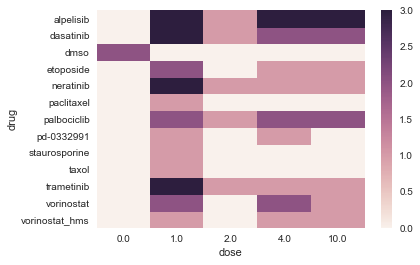

In [122]:
sns.heatmap(count_dataframe)